In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
base_dir = r"/mnt/Data/GSoC25/ML4SCI/Evaluation Task/data/dataset/dataset"

In [ ]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.data = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.data.append(os.path.join(cls_dir, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = np.load(img_path).squeeze(0)  
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
def physics_preprocess(images):
    I_max = images.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0] + 1e-6
    log_term = torch.log(I_max / (images + 1e-6))**2
    grad_x = torch.gradient(log_term, dim=3)[0]
    grad_y = torch.gradient(log_term, dim=2)[0]
    grad_xy = grad_x * grad_y  
    return torch.tanh(grad_xy)

In [ ]:
class LensPINN(nn.Module):
    def __init__(self):
        super(LensPINN, self).__init__()
        self.vit = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
        original_proj = self.vit.patch_embed.proj
        new_proj = nn.Conv2d(1, 384, kernel_size=16, stride=16)
        with torch.no_grad():
            new_proj.weight.copy_(original_proj.weight.mean(dim=1, keepdim=True))
            new_proj.bias.copy_(original_proj.bias)
        self.vit.patch_embed.proj = new_proj
        self.vit.head = nn.Identity()
        self.alpha_proj = nn.Linear(384, 150*150*2)
        self.cnn = resnet18(pretrained=True)
        self.cnn.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 3)

    def lensing_equation(self, theta_I, alpha):
        batch_size = theta_I.size(0)  
        alpha = alpha.view(batch_size, 150, 150, 2)  
        alpha_mean = alpha.mean(dim=-1)  
        theta_S = theta_I - alpha_mean.unsqueeze(1)  
        return theta_S.clamp(0, 1)

    def forward(self, x):
        vit_features = self.vit(x)  
        alpha = self.alpha_proj(vit_features)  
        theta_S = self.lensing_equation(x, alpha)  
        combined_input = torch.cat([x, theta_S], dim=1)  
        return self.cnn(combined_input)  

In [ ]:
#PINN model Enhanced
class LensPINN2(nn.Module):
    def __init__(self):
        super(LensPINN2, self).__init__()
        self.vit = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
        original_proj = self.vit.patch_embed.proj
        new_proj = nn.Conv2d(1, 384, kernel_size=16, stride=16)
        with torch.no_grad():
            new_proj.weight.copy_(original_proj.weight.mean(dim=1, keepdim=True))
            new_proj.bias.copy_(original_proj.bias)
        self.vit.patch_embed.proj = new_proj
        self.vit.head = nn.Identity()
        self.alpha_proj = nn.Linear(384, 150*150*2)
        self.cnn = resnet18(pretrained=True)
        self.cnn.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 3)

    def lensing_equation(self, theta_I, alpha):
        batch_size = theta_I.size(0)
        alpha = alpha.view(batch_size, 150, 150, 2)
        theta = torch.norm(theta_I, dim=1, keepdim=True)
        theta_E = alpha.mean(dim=(2, 3)).mean(dim=1, keepdim=True).view(batch_size, 1, 1, 1)
        alpha_sis = theta_E * theta_I / (theta + 1e-6)
        theta_S = theta_I - alpha_sis
        theta_S = theta_S.clamp(0, 149)
        return theta_S
    
    def forward(self, x):
        vit_features = self.vit(x)  
        alpha = self.alpha_proj(vit_features)  
        theta_S = self.lensing_equation(x, alpha)  
        combined_input = torch.cat([x, theta_S], dim=1)  
        return self.cnn(combined_input) 

In [ ]:
def train_model(model, train_loader, val_loader, epochs=50, device=device):
    criterion = nn.CrossEntropyLoss()
    physics_criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    best_auc = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            ce_loss = criterion(outputs, labels)
            vit_features = model.vit(images)
            alpha = model.alpha_proj(vit_features)
            theta_S = model.lensing_equation(images, alpha)
            alpha_reshaped = alpha.view(images.size(0), 150, 150, 2).mean(dim=-1).unsqueeze(1)
            physics_loss = physics_criterion(theta_S, images - alpha_reshaped)
            loss = ce_loss + 0.1 * physics_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
               
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        auc_score = roc_auc_score(val_labels, val_preds, multi_class='ovr')
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Val AUC: {auc_score:.4f}')

        if auc_score > best_auc:
            best_auc = auc_score
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')


In [ ]:
def evaluate_model(model, val_loader, device=device):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    test_preds = np.concatenate(test_preds)
    test_labels = np.concatenate(test_labels)

    fpr, tpr, roc_auc = {}, {}, {}
    class_names = ['No Substructure', 'Subhalo', 'Vortex']
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, test_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.__class__.__name__}')
    plt.legend()
    plt.show()

    print(f"AUC Scores for {model.__class__.__name__}:", roc_auc)

In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(90), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)  
])
train_dataset = LensingDataset(base_dir, split='train', transform=transform)
val_dataset = LensingDataset(base_dir, split='val')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [13]:
torch.cuda.empty_cache()

Using cache found in /home/eman/.cache/torch/hub/facebookresearch_dino_main


Training LensPINN...
Epoch 1/50, Loss: 1.1111, Val AUC: 0.5056
Epoch 2/50, Loss: 1.1067, Val AUC: 0.4938
Epoch 3/50, Loss: 1.1060, Val AUC: 0.5007
Epoch 4/50, Loss: 1.1062, Val AUC: 0.5023
Epoch 5/50, Loss: 1.1058, Val AUC: 0.5083
Epoch 6/50, Loss: 1.1044, Val AUC: 0.5103
Epoch 7/50, Loss: 1.1038, Val AUC: 0.5123
Epoch 8/50, Loss: 1.1038, Val AUC: 0.5172
Epoch 9/50, Loss: 1.1022, Val AUC: 0.5477
Epoch 10/50, Loss: 1.0753, Val AUC: 0.6557
Epoch 11/50, Loss: 0.9689, Val AUC: 0.7869
Epoch 12/50, Loss: 0.8651, Val AUC: 0.8362
Epoch 13/50, Loss: 0.7792, Val AUC: 0.8451
Epoch 14/50, Loss: 0.6924, Val AUC: 0.8793
Epoch 15/50, Loss: 0.6121, Val AUC: 0.9215
Epoch 16/50, Loss: 0.5402, Val AUC: 0.9322
Epoch 17/50, Loss: 0.4739, Val AUC: 0.9473
Epoch 18/50, Loss: 0.4311, Val AUC: 0.9573
Epoch 19/50, Loss: 0.3891, Val AUC: 0.9708
Epoch 20/50, Loss: 0.3556, Val AUC: 0.9690
Epoch 21/50, Loss: 0.3332, Val AUC: 0.9702
Epoch 22/50, Loss: 0.3097, Val AUC: 0.9760
Epoch 23/50, Loss: 0.2857, Val AUC: 0.9734

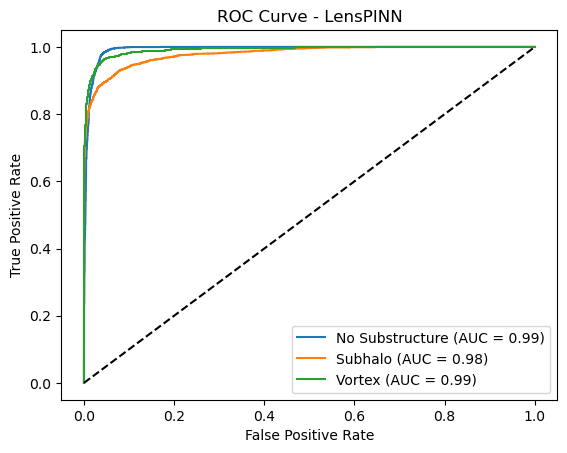

AUC Scores for LensPINN: {0: 0.9928658799999999, 1: 0.97956428, 2: 0.9917847999999999}


In [ ]:
# Train and evaluate PINN
pinn = LensPINN().to(device)
print("Training LensPINN...")
train_model(pinn, train_loader, val_loader, epochs=50)
pinn.load_state_dict(torch.load('best_LensPINN.pth'))
evaluate_model(pinn, val_loader)

Using cache found in /home/eman/.cache/torch/hub/facebookresearch_dino_main


Training LensPINN...
Epoch 1/50, Loss: 1.1307, Val AUC: 0.5247
Epoch 2/50, Loss: 1.0444, Val AUC: 0.7300
Epoch 3/50, Loss: 0.8315, Val AUC: 0.8246
Epoch 4/50, Loss: 0.6742, Val AUC: 0.8892
Epoch 5/50, Loss: 0.5863, Val AUC: 0.8994
Epoch 6/50, Loss: 0.5361, Val AUC: 0.9429
Epoch 7/50, Loss: 0.4942, Val AUC: 0.9496
Epoch 8/50, Loss: 0.4684, Val AUC: 0.9298
Epoch 9/50, Loss: 0.4379, Val AUC: 0.9537
Epoch 10/50, Loss: 0.4203, Val AUC: 0.9521
Epoch 11/50, Loss: 0.4014, Val AUC: 0.9242
Epoch 12/50, Loss: 0.3863, Val AUC: 0.9427
Epoch 13/50, Loss: 0.3782, Val AUC: 0.9674
Epoch 14/50, Loss: 0.3590, Val AUC: 0.9660
Epoch 15/50, Loss: 0.3554, Val AUC: 0.9568
Epoch 16/50, Loss: 0.3510, Val AUC: 0.9729
Epoch 17/50, Loss: 0.3362, Val AUC: 0.9674
Epoch 18/50, Loss: 0.3277, Val AUC: 0.9676
Epoch 19/50, Loss: 0.3268, Val AUC: 0.9721
Epoch 20/50, Loss: 0.3180, Val AUC: 0.9765
Epoch 21/50, Loss: 0.3151, Val AUC: 0.9595
Epoch 22/50, Loss: 0.3060, Val AUC: 0.9626
Epoch 23/50, Loss: 0.3031, Val AUC: 0.9734

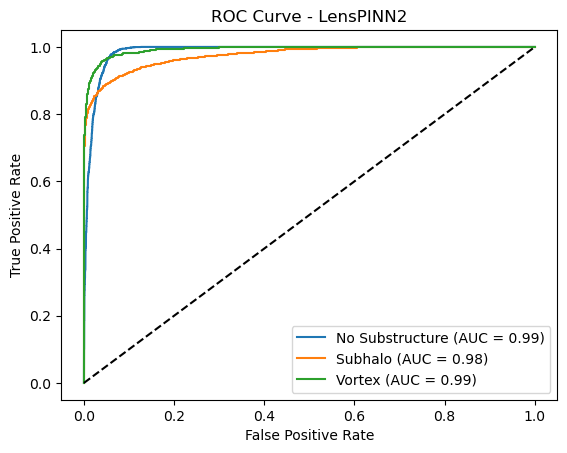

AUC Scores for LensPINN2: {0: 0.98706996, 1: 0.97532536, 2: 0.99223264}


In [ ]:
torch.cuda.empty_cache()
# Train and evaluate updated PINN
pinn = LensPINN2().to(device)
print("Training LensPINN2...")
train_model(pinn, train_loader, val_loader, epochs=50)
pinn.load_state_dict(torch.load('best_LensPINN2.pth'))
evaluate_model(pinn, val_loader)